In [1]:
from qutip import *

import numpy as np
from numpy import pi as pi
from numpy import exp as exp
from numpy import sqrt as sqrt

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20,10)
plt.rcParams['font.size'] = 12
from scipy.optimize import curve_fit as cf

In [2]:
def bin_data(xs, ys, res):
    xs_binned = np.zeros(int(xs.size//res))
    ys_binned = np.zeros_like(xs_binned)
    
    for i in range(int(xs.size//res)-1):
        xs_binned[i] = np.mean(xs[res*i:res*(i+1)])
        ys_binned[i] = np.mean(ys[res*i:res*(i+1)])
        
    xs_binned[-1] = np.mean(xs[-(res+1):-1])
    ys_binned[-1] = np.mean(ys[-(res+1):-1])
    
    return xs_binned, ys_binned

def boltzmann(gs, T):
    return np.exp(-6.26e-34*gs*1e9/(1.38e-23*T))

def sigmoid(t, risetime, t0):
    a = risetime/(2*4.4)
    return 1/(np.exp(-(t-t0)/a)+1)

def pulse_sig(t, t0, width, risetime=1):
    return np.where(t<width/2+t0, sigmoid(t,risetime,t0),1-sigmoid(t,risetime,t0+width))

def pulse_rect(t, t0, width):
    return np.where( (t0<t) & (t<(width+t0)), 1.0, 0.0)

# Initializing system composed of 6 levels
The corresponding collapse operators c_ops for a master equation solver are initialized according to the groundstate splitting <b>$gs$</b> and temperature <b>$T$</b> for <b>$T_{1,orb}(gs, T)$</b>, the relax. times <b>$T_{1,opt}$</b>, <b>$T_{1,spin}$</b> and branching ratios of orbital $\eta_\mathrm{opt}$ and spin processes $\eta_\mathrm{spin}$

In [3]:
Nsts = 6
sts = dict()
sts['g1'] = basis(Nsts, 0)
sts['g2'] = basis(Nsts, 1)
sts['m1'] = basis(Nsts, 2)
sts['m2'] = basis(Nsts, 3)
sts['e1'] = basis(Nsts, 4)
sts['e2'] = basis(Nsts, 5)

def initialize_collapses(gs, T, eta_spin, eta_opt, Gamma1_opt, Gamma1_spin):
    # 40ns is measured @5K and 46GHz ground-state splitting
    T1_orb = (46/gs)**3*40
    print("T1_orb: ", T1_orb)
    Gamma1_orb = 1/(1+boltzmann(gs,T))*1/(2*pi*T1_orb)    
    Gamma1_orb_em = Gamma1_orb
    Gamma1_orb_abs = boltzmann(gs, T) * Gamma1_orb_em
    
    c_ops = [        
        sqrt(Gamma1_opt)*(sts['g1'] + 1/eta_spin*sts['g2'] + 1/eta_opt*(1/eta_spin*sts['m1'] + sts['m2']))*sts['e2'].dag(),
        sqrt(Gamma1_opt)*(sts['g1'] + 1/eta_spin*sts['g2'] + 1/eta_opt*(sts['m1'] + 1/eta_spin*sts['m2']))*sts['e1'].dag(),
        (sqrt(Gamma1_orb_em) * sts['g1'] + sqrt(Gamma1_spin)*sts['m2'])*sts['m1'].dag(),
        (sqrt(Gamma1_orb_em) * sts['g2'] + sqrt(Gamma1_spin)*sts['m1'])*sts['m2'].dag(),
        (sqrt(Gamma1_orb_abs) * sts['m1'] + sqrt(Gamma1_spin)*sts['g2'])*sts['g1'].dag(),
        (sqrt(Gamma1_orb_abs) * sts['m2'] + sqrt(Gamma1_spin)*sts['g1'])*sts['g2'].dag()
    ]
    return c_ops

In [4]:
cmap = mpl.cm.get_cmap("viridis_r", Nsts)
kwargs_data = {
    'ls':'', 
    'marker':'o', 
    'markerfacecolor':'#fff',
    'markersize':5
#     'alpha':.5
}
kwargs_fit = {
    'linestyle':'-', 
    'linewidth':2,
    'alpha':.5
}
kwargs_fills = {
    'linestyle': '--',
    'linewidth': 2,
    'edgecolor': '#666',
    'alpha':.3
}

C:\Users\Marco\AppData\Local\Temp\ipykernel_344\2812573295.py:19: RuntimeWarning: overflow encountered in exp
  return 1/(np.exp(-(t-t0)/a)+1)


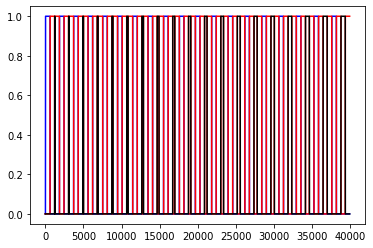

19950


In [7]:
dt = 2
T = 600
tau_stp = 30
tau_str = tau_stp
tau_stop = 600
taus = np.arange(tau_str, tau_stop, tau_stp)

L = len(taus)* 3*T + np.sum(taus)
t = np.arange(0, L, dt)

t0 = 20
pulse_risetime = 2

reset_seq = np.zeros_like(t, dtype=float)
raman_seq = np.zeros_like(t, dtype=float)
init_seq = np.zeros_like(t, dtype=float)

for tau in taus:
    reset_seq += pulse_sig(t, t0, T, pulse_risetime)
    t0 += T
    init_seq += pulse_sig(t, t0, T, pulse_risetime)
    t0 += T
    raman_seq += pulse_sig(t, t0, tau, pulse_risetime)
    t0 += tau
    init_seq += pulse_sig(t, t0, T, pulse_risetime)
    t0 += T

plt.plot(t, reset_seq, '-b')
plt.plot(t, init_seq, '-r')
plt.plot(t, raman_seq, '-k')
plt.show()
print(len(t))

# Initialize System Parameters
$\Omega_{1,2}$  are Rabi frequencies of transitions with spin-cycling $|g_1><e_1|$ and spin-flipping $|g_2><e_1|$ properties. The Rabi frequencies are related by the spin branching ratio $\eta_{\mathrm{spin}}$ as a result of spin-mixing, $\Omega_2 = \frac{\Omega_1}{\sqrt{\eta_{\mathrm{spin}}}}  = \frac{\sqrt{s/2}\Gamma_{\mathrm{opt}}}{\sqrt{\eta_{\mathrm{spin}}}}$, where $s = \frac{p}{p_\mathrm{sat}}$ is the saturation parameter.

In [101]:
eta_spin = 1
eta_opt = 2
Gamma1_opt = 1/(2*pi*1.7)
Gamma1_spin = 1/(2*pi*2000)
c_ops = initialize_collapses(gs=600, T=5, eta_spin=eta_spin, eta_opt=eta_opt, Gamma1_opt=Gamma1_opt, Gamma1_spin=Gamma1_spin)

# Saturation parameters
s1 = 1
s2 = s1

# Rabi frequencies
Omega1 = sqrt(s1/2)*Gamma1_opt
Omega2 = sqrt(s2/(2*eta_spin))*Gamma1_opt
Omega1 = 2*Gamma1_opt
Omega2 = 10*Gamma1_opt

# Init Hamiltonian
Hinit = Omega1/2 * sts['g1']*sts['e1'].dag()
Hinit += Hinit.dag()

# Reset Hamiltonian
Hreset = Omega1/2 * sts['g2']*sts['e2'].dag()
Hreset += Hreset.dag()

# Raman Hamiltonian
delta = 0
Delta = 2
Hraman = delta/2*sts['g2']*sts['g2'].dag()  + Delta/2*sts['e1']*sts['e1'].dag() + Omega1/2*sts['g1']*sts['e1'].dag() + Omega2/2*sts['g2']*sts['e1'].dag()
Hraman += Hraman.dag()

e_ops = []
labels = []
for label, state in sts.items():    
    e_ops.append(state*state.dag())
    labels.append(label)
e_ops.append(sts['e1']*sts['e1'].dag() + sts['e2']*sts['e2'].dag())
labels.append("e1 + e2")

rho0 = steadystate(Qobj(np.zeros((6,6))), c_ops)
exps = mesolve([
                [Omega2/2*(sts['g2']*sts['e1'].dag() + sts['e1']*sts['g2'].dag()), init_seq], 
                [Hraman, raman_seq]
                ], 
               rho0, t, 
               e_ops=e_ops, c_ops=c_ops,
               progress_bar=ui.TextProgressBar()).expect

T1_orb:  0.018025185185185182
10.0%. Run time:   0.23s. Est. time left: 00:00:00:02
20.0%. Run time:   0.51s. Est. time left: 00:00:00:02
30.0%. Run time:   0.77s. Est. time left: 00:00:00:01
40.0%. Run time:   1.02s. Est. time left: 00:00:00:01
50.0%. Run time:   1.27s. Est. time left: 00:00:00:01
60.0%. Run time:   1.53s. Est. time left: 00:00:00:01
70.0%. Run time:   1.79s. Est. time left: 00:00:00:00
80.0%. Run time:   2.05s. Est. time left: 00:00:00:00
90.0%. Run time:   2.39s. Est. time left: 00:00:00:00
Total run time:   2.67s


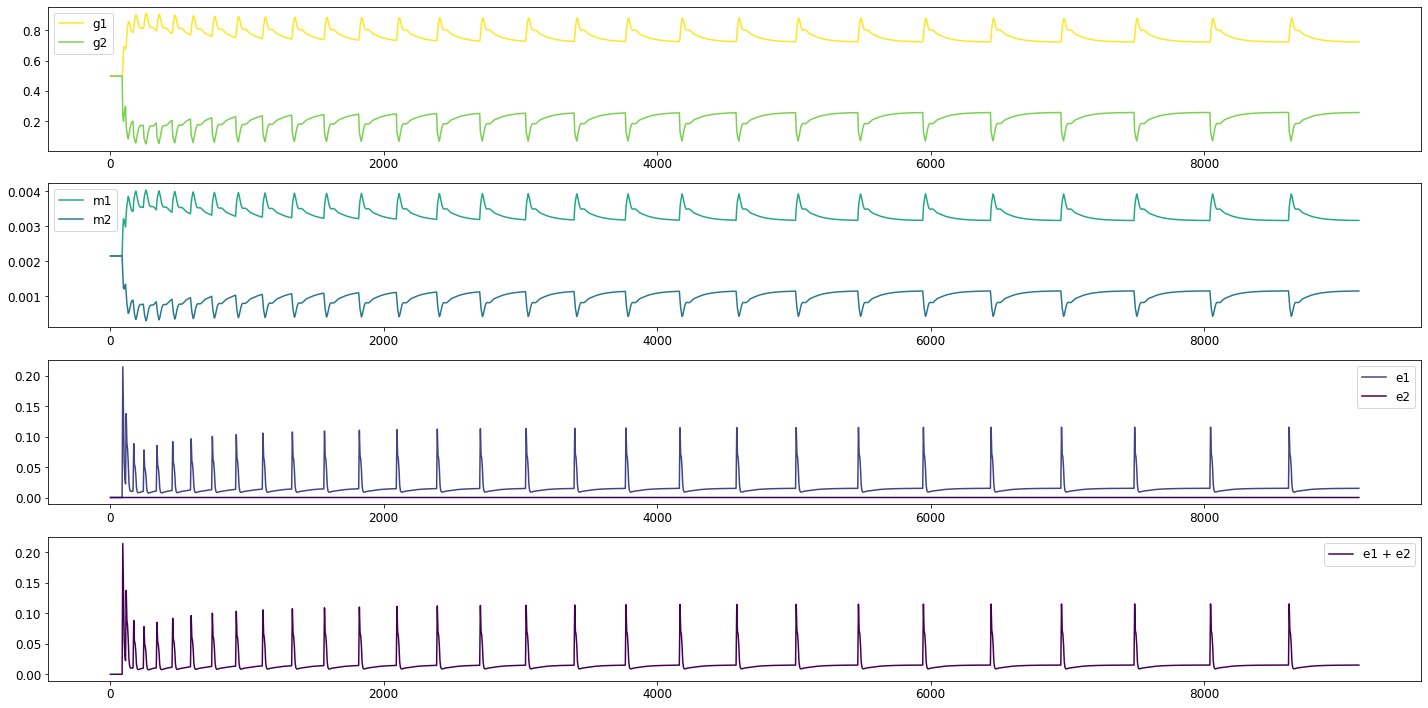

In [102]:
fig, axs = plt.subplots(4,1)
for i, exp in enumerate(exps):
    axs[i//2].plot(*bin_data(t, exp, int(5/dt)), color=cmap(i), label=labels[i])
    axs[i//2].legend()
plt.tight_layout()

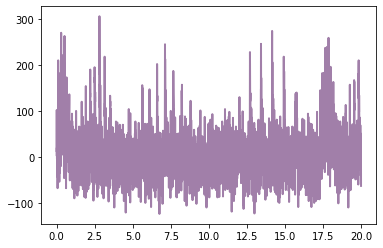

In [46]:
data = np.genfromtxt(r"Histogram_2022-12-02_22-53-19.txt")
ts = data[1:,0]*1e-6
cts = data[1:,1]

hist, bins = np.histogram(cts, bins=200)
bins_ctr = (bins[1:] + bins[:-1])/2

gaussian = lambda x, mu, sigma, A, c: A*np.exp(-(x-mu)**2/(2*sigma**2)) + c
p0 = (bins_ctr[np.argmax(hist)], sqrt(np.median(bins)), np.amax(hist), np.amin(hist))
popt, pcov = cf(gaussian, bins_ctr, hist, p0=p0)
mu, sigma, A, c = popt

cts -= mu
plt.plot(*bin_data(ts, cts, 1), color=cmap(Nsts), **kwargs_fit)
plt.show()